# HW Instructions

In this exercise, you will be working with the ViT model for image classification using the CIFAR10 dataset. 

The task will involve going through the full machine learning lifecycle, including: preprocessing and exploratory data analysis, model implementation and training, tuning, and evaluation. 

It is assumed that you have some prior experience in the field from previous assignments. This assignment allows for flexibility in exploring and implementing solutions as you see fit.
Make sure you read the instructions carefully.

In [1]:
# feel free to add any imports you might need (as long as it is part of the course environment)
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.vision_transformer import Encoder

# Added by roy
from pathlib import Path
import matplotlib.pyplot as plt
from random import randrange
import seaborn as sns
from torch.utils.data.sampler import SubsetRandomSampler
import math
from collections import OrderedDict
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional

In [2]:
DEBUG_MODE: bool = False

# Data Loading

In [3]:
### Added preparations

path = './' # './'

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10(path, train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(path, train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
### Added preparations

IDX_TO_LABEL = {v: k for k, v in train_dataset.class_to_idx.items()}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

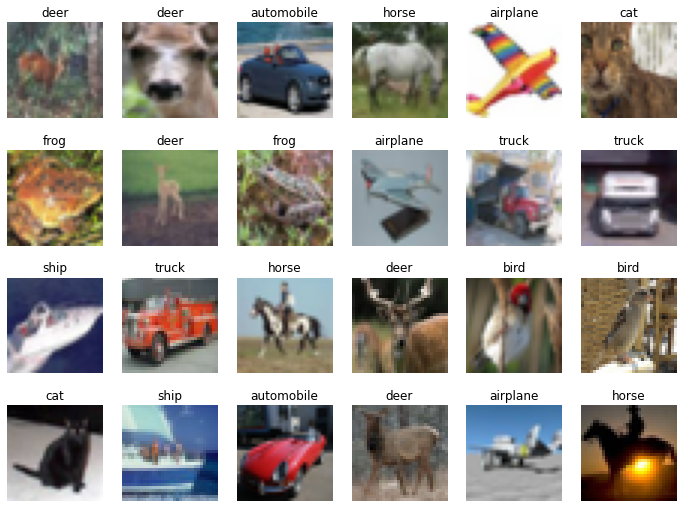

In [6]:
#############################################################################
# TO DO:                                                                    #
# plot a couple of images with their corresponding labels                   #
#############################################################################

cols = 6
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 9))

for x in range(rows):
    for y in range(cols):
        rnd_idx = randrange(len(train_dataset.data))
        
        axs[x, y].set_title(IDX_TO_LABEL[train_dataset.targets[rnd_idx]])
        axs[x, y].imshow(train_dataset.data[rnd_idx])
        axs[x, y].set_axis_off()

plt.show() 

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## A bit of exploratory data analysis (EDA)

Training set shapes
Samples: (50000, 32, 32, 3)
Labels: 50000

Training set data distribution


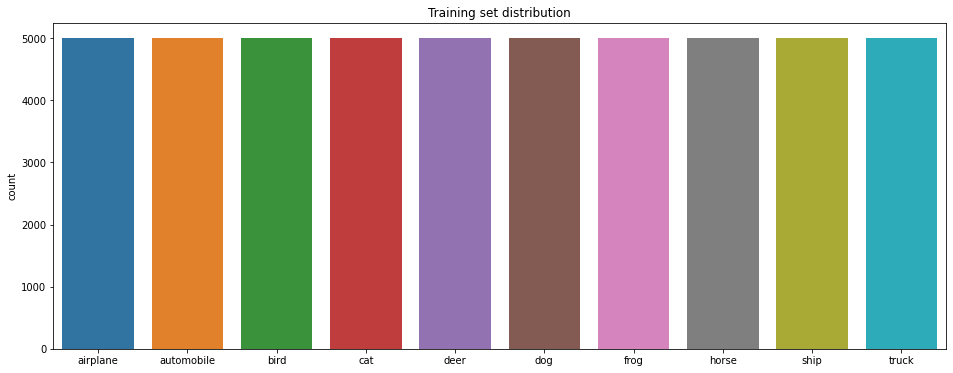



train_dataset.__dict__.keys() contents:
train_dataset attribute: <root> is of type <class 'str'> and has value: ./
train_dataset attribute: <transform> is of type <class 'torchvision.transforms.transforms.Compose'> and has value: Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
train_dataset attribute: <target_transform> is of type <class 'NoneType'> and has value: None
train_dataset attribute: <transforms> is of type <class 'torchvision.datasets.vision.StandardTransform'> and has value: StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
train_dataset attribute: <train> is of type <class 'bool'> and has value: True
train_dataset attribute: <data> is of type <class 'numpy.ndarray'> - value not printed because it is large
train_dataset attribute: <targets> is of type <class 'list'> - value not printed because it is large
train_dataset attribute: <classes> is o

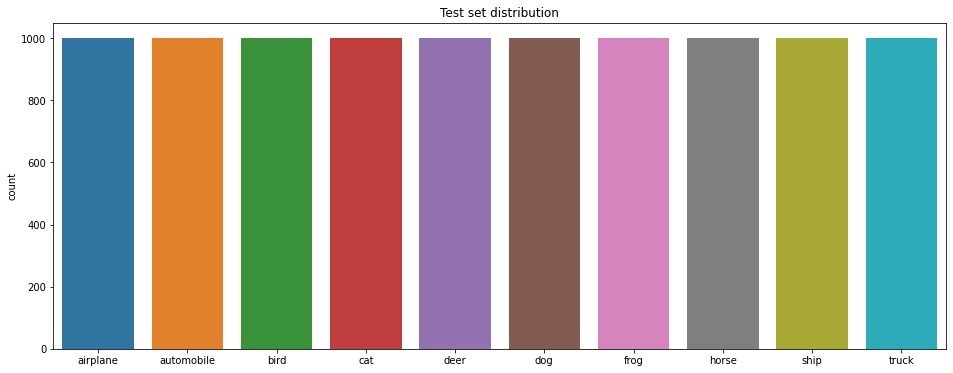



test_dataset.__dict__.keys() contents:
train_dataset attribute: <root> is of type <class 'str'> and has value: ./
train_dataset attribute: <transform> is of type <class 'torchvision.transforms.transforms.Compose'> and has value: Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
train_dataset attribute: <target_transform> is of type <class 'NoneType'> and has value: None
train_dataset attribute: <transforms> is of type <class 'torchvision.datasets.vision.StandardTransform'> and has value: StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
train_dataset attribute: <train> is of type <class 'bool'> and has value: False
train_dataset attribute: <data> is of type <class 'numpy.ndarray'> - value not printed because it is large
train_dataset attribute: <targets> is of type <class 'list'> - value not printed because it is large
train_dataset attribute: <classes> is o

In [7]:
#############################################################################
# TO DO:                                                                    #
# Figure out the size of the dataset:                                       #
# How many samples in train/test?                                            #
# How many labels? How many samples per label?                              #
# Try access train_dataset.__dict__.keys() to see which attributes          #
# are available on train_dataset.                                           #
#############################################################################

### TRAIN

print('Training set shapes')
print(f'Samples: {train_dataset.data.shape}')
print(f'Labels: {len(train_dataset.targets)}')
print('\nTraining set data distribution')

fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(train_dataset.targets).map(IDX_TO_LABEL), 
    order=IDX_TO_LABEL.values(),
).set_title('Training set distribution')

plt.show()

print(f'\n\ntrain_dataset.__dict__.keys() contents:')
for key, value in train_dataset.__dict__.items():
    if key not in ['data', 'targets']:
        print(f'train_dataset attribute: <{key}> is of type {type(value)} and has value: {value}')
    else:
        print(f'train_dataset attribute: <{key}> is of type {type(value)} - value not printed because it is large')



### TEST

print('\nTest set shapes')
print(f'Samples: {test_dataset.data.shape}')
print(f'Labels: {len(test_dataset.targets)}')
print('\Test set data distribution')

fig, ax = plt.subplots(figsize=(16, 6))

sns.countplot(
    x=pd.Series(test_dataset.targets).map(IDX_TO_LABEL), 
    order=IDX_TO_LABEL.values(),
).set_title('Test set distribution')

plt.show()

print(f'\n\ntest_dataset.__dict__.keys() contents:')
for key, value in test_dataset.__dict__.items():
    if key not in ['data', 'targets']:
        print(f'train_dataset attribute: <{key}> is of type {type(value)} and has value: {value}')
    else:
        print(f'train_dataset attribute: <{key}> is of type {type(value)} - value not printed because it is large')



#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Create DataLoaders

In [8]:
#############################################################################
# TO DO:                                                                    #
# Decide on a batch size (which later can be tunned)                        #
#############################################################################

## batch size definition
batch_size = 64

## NOTE !
## in one of the next cells, we are asked to slpit the train dataset into train and validation data
## this is not asked here, but will be done here in advance

# Prep
validation_split = .2
shuffle_dataset = True
random_seed= 42
dataset_size = len(train_dataset)

# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=train_sampler,
    num_workers=2,
)

# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


validation_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=2
)


test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,
)


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

# Building ViT Model

In the next section, you will construct a Vision Transformer, a transformer-based image classifier. The goal of the ViT model is to bring advancements from the natural language processing field to computer vision. 

For this exercise, you will be required to implement the ViT model using a pre-built Encoder from the PyTorch library. Building the encoder can be challenging, so we have eliminated that step for you. If you are not familiar with the ViT model, it is highly recommended that you gain an understanding of its workings before beginning implementation. There is a ton of information available online, here is a pretty informative source:
https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline

In this assignment, you will be using a pre-built Encoder from the PyTorch library, which has already been loaded in the provided code. Therefore, you do not need to worry about the complexities of transformer computations when referring to the link provided.

In [9]:
class ViT(nn.Module):
    def __init__(
        self, 
        image_size, 
        patch_size, 
        num_classes, 
        num_layers, 
        num_heads, 
        hidden_dim, 
        mlp_dim, 
        dropout, 
        attention_dropout
    ):
        super().__init__()
        
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the required layers for your ViT model implementation.           #
        # Hint: For the curious among us, you can pick at pytorch's                 #
        # official implemetantion of vit (vit_b_16).                                #
        #############################################################################
        
        # assert from torchvision
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        
        # # lines from torchvision that dont exist here
        # self.representation_size = representation_size
        # self.norm_layer = norm_layer
        
        # assert sizes are correct ( TODO: 
        #                 taken from original code
        assert image_size % patch_size == 0, "Input shape indivisible by patch size!"

        # set class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        
        # calculate seq_length
        self.seq_length = (image_size // patch_size) ** 2
        self.seq_length += 1  # considering for token
        
        # Code given in this HW
        # initializing the encoder backbone
        # you should calculate the seq_length
        self.encoder = Encoder(
            seq_length=self.seq_length,
            num_layers=num_layers,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            mlp_dim=mlp_dim,
            dropout=dropout,
            attention_dropout=attention_dropout
        )
        
        ## set up breaking up the image into smaller patches
        # create
        self.conv_proj = nn.Conv2d(
            in_channels=3, out_channels=hidden_dim, 
            kernel_size=patch_size, stride=patch_size,
        )        
        # init
        fan_in = self.conv_proj.in_channels * self.conv_proj.kernel_size[0] * self.conv_proj.kernel_size[1]
        nn.init.trunc_normal_(self.conv_proj.weight, std=math.sqrt(1 / fan_in))
        if self.conv_proj.bias is not None:
            nn.init.zeros_(self.conv_proj.bias)
            
        ## set up .... ?
        # create
        heads_layers: OrderedDict[str, nn.Module] = OrderedDict()
        heads_layers["head"] = nn.Linear(hidden_dim, num_classes)
        self.heads = nn.Sequential(heads_layers)
        # init
        nn.init.zeros_(self.heads.head.weight)
        nn.init.zeros_(self.heads.head.bias)
        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
        #############################################################################
        # TO DO:                                                                    #
        # Complete the rest of the class (foward method and other helper            #
        # functions if needed).                                                     #
        #############################################################################

    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        # Unpack and set dimensions variables
        n, c, h, w = x.shape
        p = self.patch_size
        n_h = h // p
        n_w = w // p
        
        # assert sizes are correct ( TODO: 
        #                 taken from original code
        assert h == self.image_size, f"Wrong image height! Expected {self.image_size} but got {h}!"
        assert w == self.image_size, f"Wrong image width! Expected {self.image_size} but got {w}!"

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.hidden_dim, n_h * n_w)

        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        return x
    

    def forward(self, x: torch.Tensor):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        
        # Use the encoder
        x = self.encoder(x)

        # Classifier "token" as used by standard language architectures
        x = x[:, 0]

        x = self.heads(x)

        return x

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [10]:
# this is just a simple initialization, feel free to change it.
'''
Original HPs forr the model (didnt work so well)

model = ViT(
    image_size=32, 
    patch_size=8, 
    num_classes=100, 
    num_layers=2, 
    num_heads=2, 
    hidden_dim=128, 
    mlp_dim=512, 
    dropout=0.0, 
    attention_dropout=0.0,
)
'''

# NOTE: this was moved down to the HP section


'\nOriginal HPs forr the model (didnt work so well)\n\nmodel = ViT(\n    image_size=32, \n    patch_size=8, \n    num_classes=100, \n    num_layers=2, \n    num_heads=2, \n    hidden_dim=128, \n    mlp_dim=512, \n    dropout=0.0, \n    attention_dropout=0.0,\n)\n'

# Training

## IMPORTANT READ!

In the following section, you will be required to train your implementation of the ViT model as in previous assignments. However, it is important to note that training transformers can be challenging, especially when starting from scratch, as is the case in this exercise.

It is acceptable if your final model does not achieve a high accuracy score, but it is crucial to document your training experiments and demonstrate that the model is able to train correctly (i.e. the loss decreases over time). This includes noting what you tried, what parameters worked best, and providing the loss and accuracy graphs as instructed in the next sections.

A reference for training ViT on CIFAR10 can be found at https://github.com/omihub777/ViT-CIFAR. However, it's important to note that in the provided reference, the ViT model was trained using 200 epochs and over 2 hours of training.

Note 1: If the loss decreases and your model trains correctly, you are on the safe side. The focus should be on the experiments and the things you tried.

Note 2: The main goal is not to achieve a high accuracy score but to demonstrate that you understand the process.

Note 3: If your final model's performance is strictly better than a random model (accuracy of around 1/num_classes) and you have provided thorough documentation of your experiments and processes, you will receive full credit for the assignment. 

In [11]:
#############################################################################
# TO DO:                                                                    #
# Create a validation set from the training set
# Implement the training loop
# Save the loss and accuracy for both training/validation sets every couple of iterations for plotting afterwards.
#############################################################################

'''
Answers:
* training loop will be implemented below
* validation set defined in one of the cells above (dataloaders cell)
* saving the loss and accuracy will be part of the code
'''

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################


'\nAnswers:\n* training loop will be implemented below\n* validation set defined in one of the cells above (dataloaders cell)\n* saving the loss and accuracy will be part of the code\n'

In [12]:
# class TrainOutputFormat(TypedDict):
#     avg_losses: List[float]
#     total_accuracies: List[float]

In [18]:
class ModelTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, num_epochs):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_epochs = num_epochs
        
    def train_and_evaluate_model(self):
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []
        for i in range(self.num_epochs):
            print(f'\n* Working on epoch {i} ...')

            # train
            self.train_model_single_epoch()
            
            # evaluate
            train_loss, train_acc = self.evaluate_dataloder_single_epoch(self.train_loader)
            val_loss, val_acc = self.evaluate_dataloder_single_epoch(self.val_loader)
            
            # save
            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
            
            # print
            print(f'* epoch {i} complete. train: accuracy {train_acc} avg_loss_this_epoch {train_loss}')
            print(f'                      val:   accuracy {val_acc} avg_loss_this_epoch {val_loss}')

        #
        print('Finished Training')
        return train_loss_history, train_acc_history, val_loss_history, val_acc_history
            
    
    def train_model_single_epoch(self):
        print('\n*** train_model_single_epoch ***\n')
        
        for i, data in enumerate(self.train_loader):
            
            print(f'Working on minibatch {i+1}/{len(self.train_loader)}', end='\r')
            

            
            if DEBUG_MODE is True and i > 50:
                break

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward
            outputs = self.model(inputs)
            
            # backward + optimize
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            # if i % 50 == 0:
            #     print(f'DELETE: Working on minibatch {i+1}/{len(self.train_loader)}; loss: {loss.item()}')
            
        
        print('done ----') # this ends the line overwrite

    
    def evaluate_dataloder_single_epoch(self, dataloader):
        print('\n*** evaluate_dataloder_single_epoch ***\n')

        loss_per_minibatch_list = []
        correct_preds_per_minibatch = []
        
        for i, minibatch in enumerate(dataloader):
            print(f'Working on minibatch {i+1}/{len(dataloader)}', end='\r')
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = minibatch

            # forward
            outputs = self.model(inputs)
            
            # calculate loss
            loss = self.criterion(outputs, labels)
            
            # get correct predictions
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            # save results
            loss_per_minibatch_list.append(loss.item())
            correct_preds_per_minibatch.append(correct) # for accuracy results
        
        ##
        print('done ----') # this ends the line overwrite
        
        # save loss in epoch
        avg_loss_this_epoch = np.mean(loss_per_minibatch_list).item()
        
        # save accuracy in epoch
        num_samples = len(dataloader.dataset)
        total_correct_preds_this_epoch = np.sum(correct_preds_per_minibatch).item()
        accuracy_this_epoch = 100 * total_correct_preds_this_epoch / num_samples   
        
        return avg_loss_this_epoch, accuracy_this_epoch
        

In [19]:
### SET HPs FOR RUN !

In [20]:
'''
Centralized Hyper Parameters section
'''

DEBUG_MODE: bool = False
NUM_OF_EPOCHS: int = 3

# Choose model params
model = ViT(
    image_size=32, 
    patch_size=4, 
    num_classes=10, 
    num_layers=2, 
    num_heads=2, 
    hidden_dim=128, 
    mlp_dim=512, 
    dropout=0.1, 
    attention_dropout=0.1,
)

# Choose Loss function
criterion = nn.CrossEntropyLoss()  # nn.CrossEntropyLoss()

# Choose optimizer params + optimizer algorithm
optimizer_hps = {
    'lr': 0.001,  # 0.01 
}
optimizer = optim.Adam(model.parameters(), **optimizer_hps)

In [ ]:
%%time

trainer = ModelTrainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    train_loader=train_loader, 
    val_loader=validation_loader,
    num_epochs=NUM_OF_EPOCHS,
)

results = trainer.train_and_evaluate_model()


* Working on epoch 0 ...

*** train_model_single_epoch ***

done ----n minibatch 625/625

*** evaluate_dataloder_single_epoch ***

done ----n minibatch 625/625

*** evaluate_dataloder_single_epoch ***

done ----n minibatch 157/157
* epoch 0 complete. train: accuracy 31.196 avg_loss_this_epoch 1.6565510513305663
                      val:   accuracy 7.612 avg_loss_this_epoch 1.6755027011701256

* Working on epoch 1 ...

*** train_model_single_epoch ***

done ----n minibatch 625/625

*** evaluate_dataloder_single_epoch ***

done ----n minibatch 625/625

*** evaluate_dataloder_single_epoch ***

done ----n minibatch 157/157
* epoch 1 complete. train: accuracy 35.886 avg_loss_this_epoch 1.4897494972229004
                      val:   accuracy 8.778 avg_loss_this_epoch 1.5101904785557159

* Working on epoch 2 ...

*** train_model_single_epoch ***



In [ ]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = results

## Loss and Acurracy

In [ ]:
# Plot 2 graphs:
# Graph 1: Loss vs itreation for training and validation sets
# Graph 2: Accuracy vs itreation for training and validation sets

In [ ]:
def plot_graph(train_results: list, val_results: list, graph_type: str):  
    # plt.figure(0)
    plt.plot(list(range(len(train_results))), train_results, 'r--', label=f'Train {graph_type}')
    plt.plot(list(range(len(val_results))), val_results, 'r--', label=f'Validation {graph_type}')
    plt.title(f'{graph_type} change per epoch over train and validation data')  
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(graph_type)
    plt.show()

In [ ]:
%%time
plot_graph(
    train_results=train_loss_history, 
    val_results=val_loss_history, 
    graph_type='Loss')

In [ ]:
%%time
plot_graph(
    train_results=train_acc_history, 
    val_results=val_acc_history, 
    graph_type='Accuracy')

# Evaluation 

In [ ]:
# Calculate the accuracy of the final model on the test set.

In [ ]:
_, accuracy = trainer.evaluate_dataloder_single_epoch(dataloader=test_loader)

In [ ]:
print(f'accuracy of the final model on the test set: {accuracy}')

### Expirement Documentation

I ran everything on my own CPU (which was slow) so i did only a realy small amount of epochs, just to see that everything trains as expected.
I tried to play with these HPs:
- patch size [8 (original, 4, 2]
- b

I found out that ....


patch size 4 was relatively good

# Questions

##**Question:** 

Explain the importance of the positional embedding in the ViT model.

**Your answer:** 

Positional embeddings arre added to the patch embeddings to retain positional information.
the idea was inspirred by positional embeddings in NLP transformers.
Without positional embedding, the model would not be able to learn context, between the patches, i.e, the model will get a "bag of patches" and will learn the connection between them. 
in the original ViT paper in appendix D4, the authors tried to compare running the model with and without positional embeddingl. the models using positional embeddings had superior results (see table 8). this proves the importance of this embedding.
[reference: https://arxiv.org/pdf/2010.11929.pdf]

##**Question:** 

How would you evaluate the model if the number of samples per class would not be balanced?
How can you deal with class imbalance on multiclass classification?

**Your answer:** 
There are multiple ways to deal with class imbalance, i will present some of them as i understand.
- undersampling: take the amount of samples in the smallest class, and remove samples from bigger classes to achieve balance. the major and obvious drawback is that we dont use all of the available samples, and possibly lose samples with great importance in the other classes, and also other classes accuracy might drop.
- metrics choice: some evaluation metrics are less sensitive to imbalance than others, and also, a user defined weight matrix can be applied to the results to account for the imbalance.
- oversampling: synthetically generate more samples in the missing class - possibly with data augmentation techniques

there are more options, these are the first that come to mind in my opinion.